# Molecular Design with Parsl
This notebook demonstrates a simple molecular design application where we use machine learning to guide which computations we perform.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from chemfunctions import compute_vertical
from concurrent.futures import as_completed
from tqdm.notebook import tqdm
from parsl.executors import HighThroughputExecutor
from parsl.app.python import PythonApp
from parsl.app.app import python_app
from parsl.config import Config
from time import monotonic
import parsl
import pandas as pd
import numpy as np

## Define problem
We need some prerequisite data to define our molecular design problem

In [2]:
search_space = pd.read_csv('data/QM9-search.tsv', delim_whitespace=True).sample(1024)  # Our search space of molecules

In [3]:
initial_count: int = 16  # Number of calculations to run at first

In [4]:
search_count: int = 64   # Number of molecules to evaluate in total

In [5]:
batch_size: int = 8  # Number of molecules to evaluate in each batch of simulations

## Set up Parsl
Our first step is to ready our Python process to be able to distribute computations with Parsl.

_\[Some details to be filled in later\]_

For now, we use a HighThroughputExecutor run locally on your system.

In [6]:
config = Config(
    executors=[HighThroughputExecutor(
        label='local',
        cores_per_worker=2,  # Makes on worker for every two cores
        cpu_affinity='block'  # Assigns workers to specific cores
    )]
)

In [7]:
parsl.load(config)

## Make an initial dataset
We need an data to train our ML models and, so, must perform some initial simulations. We'll do that by selecting a set of molecules at random from  our search space.

But, first, we need to ready our simulator to work with Parsl. 

In [`chemfunctions.py`](./chemfunctions.py), we defined a function `compute_vertical` that computes the "vertical ionization energy" of a molecule (a measure of how much energy it takes to strip an electron off the molecule) that we need to prepare to run in parallel with Parsl.

All we need to do is wrap this function with Parsl's `python_app` function to make it ready to run in parallel.

In [8]:
compute_vertical_app = python_app(compute_vertical)
compute_vertical_app

Note how this new object is a "Python app." Running it launches the function to execute asynchronously, and we retrieve the result by calling the future.

In [9]:
future = compute_vertical_app('O') #  Run water as a demonstration (O is the SMILES for water)
future

<AppFuture super=<AppFuture at 0x7f9bc914c340 state=pending>>

In [10]:
ie = future.result()
print(f"The ionization energy of {future.task_def['args'][0]} is {ie:.2f} Ha")

The ionization energy of O is 0.67 Ha


Ok, now lets sample a few points and gather their results.

First we submit them

In [11]:
%%time
futures = [compute_vertical_app(s) for s in search_space.sample(initial_count)['smiles']]
print(f'Submitted {len(futures)} calculations to start with')

Submitted 16 calculations to start with
CPU times: user 7.37 ms, sys: 0 ns, total: 7.37 ms
Wall time: 6.67 ms


The futures Parsl produces are based on Python's [native "Future"](https://docs.python.org/3/library/concurrent.futures.html#future-objects) object,
so we can use Python's utility functions to work with them. 

As an example, we can build a loop that submits new computations if previous ones fail. This happens not too infrequently with our simulation application

In [12]:
train_data = []
while len(futures) > 0: 
    # First, get the next completed computation from the list
    future = next(as_completed(futures))
    
    # Remove it from the list of still-running tasks
    futures.remove(future)
    
    # Get the input 
    smiles = future.task_def['args'][0]
    
    # Check if the run completed successfully
    if future.exception() is not None:
        # If it failed, pick a new SMILES string at random and submit it    
        print(f'Computation for {smiles} failed, submitting a new computation')
        new_future = compute_vertical_app(search_space.sample(1).iloc[0]['smiles'])
        futures.append(new_future)
    else:
        # If it succeeded, store the result
        train_data.append({
            'smiles': smiles,
            'ie': future.result(),
            'batch': 0,
            'time': monotonic()
        })

Computation for CC12CC3C(C1)C23 failed, submitting a new computation


We now should have an initial set of molecules

In [13]:
train_data = pd.DataFrame(train_data)
train_data.head()

,smiles,ie,batch,time
0,N#CC1(CO1)C#N,0.575725,0,16612.059158
1,OC1C2CC3(CC3)C1O2,0.509258,0,16612.182874
2,CC1CC1CC#C,0.496150,0,16614.398306
3,CC(CC#N)OC(N)=O,0.528535,0,16614.737728
4,CCNC(=O)C(O)C#C,0.508447,0,16615.356969


## Train an initial machine learning model, use to screen candidates
Our next step for Parsl is to produce a machine learning model to estimate the outcome of new computations and use it to scan the search space.

To start, let's make a function that takes our existing data and uses it to train a model. We are going to use RDKit and scikit-learn to train a nearest-neighbor model that uses Morgan fingerprints to define similarity (see [notes from a UChicago AI course](https://github.com/WardLT/applied-ai-for-materials/blob/main/molecular-property-prediction/chemoinformatics/2_ml-with-fingerprints.ipynb) for more detail)

We want it to run remotely, so we create the function with a `python_app` decorator so that Parsl can run it remotely

In [14]:
@python_app
def train_model(train_data):
    """Train a machine learning model using Morgan Fingerprints.
    
    Args:
        train_data: Dataframe with a 'smiles' and 'ie' column
            that contains molecule structure and property, respectfully.
    Returns:
        A trained model
    """
    # Imports for python functions run remotely must be defined inside the 
    #  function if you define them inside a Jupyter notebook.
    from chemfunctions import MorganFingerprintTransformer
    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.pipeline import Pipeline
    
    
    model = Pipeline([
        ('fingerprint', MorganFingerprintTransformer()),
        ('knn', KNeighborsRegressor(n_neighbors=4, weights='distance', metric='jaccard', n_jobs=-1))  # n_jobs = -1 lets the model run all available processors
    ])
    
    return model.fit(train_data['smiles'], train_data['ie'])

Let's start it to run asynchronously

In [15]:
train_future = train_model(train_data)

A great feature of Parsl is that it can create workflows on-the-fly from Python. To do so, we pass the future created by executing one function an input to another Parsl function.

As an example, let's create a function that uses the trained model to run inference on a large set of molecules and then another that takes a many predictions an contatenates them into a single .

In [16]:
@python_app
def run_model(model, smiles):
    """Run a model on a list of smiles strings
    
    Args:
        model: Trained model that takes SMILES strings as inputs
        smiles: List of molecules to evaluate
    Returns:
        A dataframe with the molecules and their predicted outputs
    """
    import pandas as pd
    pred_y = model.predict(smiles)
    return pd.DataFrame({'smiles': smiles, 'ie': pred_y})

In [17]:
@python_app
def combine_inferences(inputs=[]):
    import pandas as pd
    return pd.concat(inputs, ignore_index=True)

In [18]:
# Chunk the search space into smaller pieces, so that each can run in parallel
inference_futures = [run_model(train_future, chunk) for chunk in np.array_split(search_space['smiles'], 64)]

In [19]:
# We pass the inputs explicitly as a kwargs named "inputs" for Parsl to recognize this as a "reduce" step
#  See: https://parsl.readthedocs.io/en/stable/userguide/workflow.html#mapreduce
predictions = combine_inferences(inputs=inference_futures).result()

In [20]:
predictions.sort_values('ie', ascending=False).head(5)

,smiles,ie
55,N#CC1(CO1)C#N,0.575725
229,CC1(CCN1)C#N,0.533694
907,CN1CCC(O)(C1)C#N,0.533417
225,O=C(C#N)C1CO1,0.532875
693,CC1(CC#N)COC=N1,0.532822


We now have the ability to train a model and use it to identify molecules that are likely to be good next choices for simulations. Time to build a model-in-the-loop workflow

## Model-in-the-Loop Workflow
We are going to build an application that uses a machine learning model to pick a batch of simulations, runs the simulations in paralle, and then uses the data to retrain the model before repeating the loop

In [21]:
# Loop until we have run the desired number of simulations
with tqdm(total=search_count) as prog_bar:
    prog_bar.update(len(train_data))
    batch = 1
    already_ran = set(train_data['smiles'])
    while len(train_data) < search_count:
        # Launch the model train and run all-inference workflow
        train_future = train_model(train_data)
        inference_futures = [run_model(train_future, chunk) for chunk in np.array_split(search_space['smiles'], 64)]
        predictions = combine_inferences(inputs=inference_futures).result()

        # Sort the predictions in descending order, and submit new molecules from them
        predictions.sort_values('ie', ascending=False, inplace=True)
        sim_futures = []
        for smiles in predictions['smiles']:
            if smiles not in already_ran:
                sim_futures.append(compute_vertical_app(smiles))
                already_ran.add(smiles)
                if len(sim_futures) >= batch_size:
                    break

        # As they complete, store successful results
        new_results = []
        for future in as_completed(sim_futures):
            if future.exception() is None:
                prog_bar.update(1)
                new_results.append({
                    'smiles': future.task_def['args'][0],
                    'ie': future.result(),
                    'batch': batch, 
                    'time': monotonic()
                })
                
        # Update the training data and repeat
        batch += 1
        train_data = pd.concat((train_data, pd.DataFrame(new_results)), ignore_index=True)

  0%|          | 0/64 [00:00<?, ?it/s]

Plot to illustrate the performance of the engine

In [22]:
train_data['time'] = train_data['time'] - train_data['time'].min()

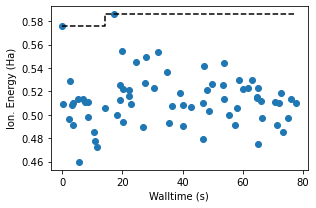

In [23]:
fig, ax = plt.subplots(figsize=(4.5, 3.))

ax.scatter(train_data['time'], train_data['ie'])
ax.step(train_data['time'], train_data['ie'].cummax(), 'k--')

ax.set_xlabel('Walltime (s)')
ax.set_ylabel('Ion. Energy (Ha)')

fig.tight_layout()

You can see how our search program finds better molecules over time!